# **TALLER 2**

Daniel Felipe Vargas Ulloa - 202123899
MINE-4101: Ciencia de Datos Aplicada

## **1. Preparación**

Para la realización de este taller, se importan las librerías necesarias y se descargará el conjunto de datos directamente del repositorio de Grocery Store Dataset donde se encuentra alojado. Para este ultimo paso es vital tener conexión a internet y tener git instalado en el entorno de trabajo como se especificó en la descripción del repositorio.

In [60]:
# Install all required libraries if not already installed using pip
import subprocess
import sys

!{sys.executable} -m pip install -r requirements.txt | grep -v 'already satisfied'

In [ ]:
# pandas
import pandas as pd

# numpy version before 2.0.0
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# tensorflow
import imgaug as ia

# os
import os

# Image manipulation
from PIL import Image
import imgaug.augmenters as iaa
import imageio.v2 as imageio

In [62]:
# ensures the root directory is not the python path but the root of the project 'MINE-4101-Taller-2'
if os.path.basename(os.getcwd()) == 'src':
    os.chdir('..')

In [ ]:
# Clona el repositorio de github con el dataset si no existe ya en el entorno

if not os.path.exists('GroceryStoreDataset'):
    !git clone https://github.com/marcusklasson/GroceryStoreDataset.git

# Carga el dataset
df = pd.read_csv('GroceryStoreDataset/dataset/classes.csv')

In [64]:
# Configuración de pandas para extender el número de filas y columnas mostradas
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', 200)
pd.set_option("display.max_rows", 100)
pd.set_option('expand_frame_repr', False)
np.set_printoptions(threshold=sys.maxsize)

## **2. Entendimiento y preparación de los datos**

### **2.1. Entendimiento de los datos**

In [17]:
# Reporte de dimensiones del dataset
print(f"Dimensiones del dataset: {df.shape}")

Dimensiones del dataset: (81, 6)


In [18]:
# Información general sobre las columnas
print("\nInformación del dataset:")
print(df.info())


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Class Name (str)                81 non-null     object
 1   Class ID (int)                  81 non-null     int64 
 2   Coarse Class Name (str)         81 non-null     object
 3   Coarse Class ID (int)           81 non-null     int64 
 4   Iconic Image Path (str)         81 non-null     object
 5   Product Description Path (str)  81 non-null     object
dtypes: int64(2), object(4)
memory usage: 3.9+ KB
None


In [19]:
# Mostrar el nombre de las columnas
print(df.columns)

Index(['Class Name (str)', 'Class ID (int)', 'Coarse Class Name (str)',
       'Coarse Class ID (int)', 'Iconic Image Path (str)',
       'Product Description Path (str)'],
      dtype='object')


In [20]:
# Mostrar un dato de ejemplo
print(df.head(1))

   Class Name (str)  Class ID (int) Coarse Class Name (str)  Coarse Class ID (int)                                                                   Iconic Image Path (str)                                                                 Product Description Path (str)
0  Golden-Delicious               0                   Apple                      0  /iconic-images-and-descriptions/Fruit/Apple/Golden-Delicious/Golden-Delicious_Iconic.jpg  /iconic-images-and-descriptions/Fruit/Apple/Golden-Delicious/Golden-Delicious_Description.txt


#### **2.2. Preparación de los datos**

Para realmente entender la realidad del conjunto de datos que estamos tratando, resulta fundamental cargar las imagenes y visualizarlas para tener una idea de lo que se está tratando. Para ello, se importan las librerías necesarias y se carga una imagen de ejemplo.

In [21]:
# Cargar la lista de imagenes de cada uno de los productos, por ahoar se usará granularidad de prpducto y no de tipo de producto

# Carga los 3 datasets, GroceryStoreDataset/test, GroceryStoreDataset/train y GroceryStoreDataset/val

# Define the column names
column_names = ['Image Path', 'Class ID', 'Coarse Class ID']

# Carga el dataset de entrenamiento
df_train = pd.read_csv('GroceryStoreDataset/dataset/train.txt', names=column_names, header=None)

# Carga el dataset de validación
df_val = pd.read_csv('GroceryStoreDataset/dataset/val.txt', names=column_names, header=None)

# Carga el dataset de prueba
df_test = pd.read_csv('GroceryStoreDataset/dataset/test.txt', names=column_names, header=None)

# Print the first few rows of each dataframe to verify

In [22]:
# imprime el numero de elementos en cada dataset
print(f"Numero de elementos en el dataset de entrenamiento: {df_train.shape[0]}")
print(f"Numero de elementos en el dataset de validación: {df_val.shape[0]}")
print(f"Numero de elementos en el dataset de prueba: {df_test.shape[0]}")

Numero de elementos en el dataset de entrenamiento: 2640
Numero de elementos en el dataset de validación: 296
Numero de elementos en el dataset de prueba: 2485


Enfocaremos nuestro análisis en el dataset de entrenamiento, paar determinar si es necesario realizar tecnicas de aumento de datos o aplicar alguna transformación a las imagenes.

In [23]:
# Dato de ejemplo
print(df_train.head(1))

                                                    Image Path  Class ID  Coarse Class ID
0  train/Fruit/Apple/Golden-Delicious/Golden-Delicious_001.jpg         0                0


In [24]:
# Add prefix to 'Image Path' column in df_train
df_train['Image Path'] = df_train['Image Path'].apply(lambda x: 'GroceryStoreDataset/dataset/' + x)

# Add prefix to 'Image Path' column in df_test
df_test['Image Path'] = df_test['Image Path'].apply(lambda x: 'GroceryStoreDataset/dataset/' + x)

# Add prefix to 'Image Path' column in df_val
df_val['Image Path'] = df_val['Image Path'].apply(lambda x: 'GroceryStoreDataset/dataset/' + x)

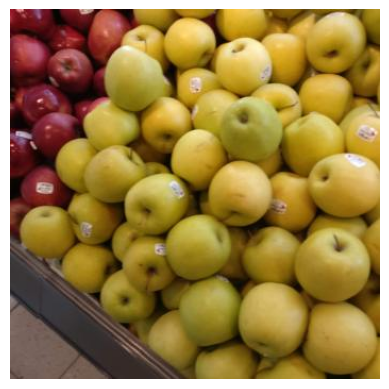

In [25]:
from PIL import Image

# Load the image
image_path = 'GroceryStoreDataset/dataset/train/Fruit/Apple/Golden-Delicious/Golden-Delicious_002.jpg'
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

In [26]:
from PIL import Image

# Function to get image resolution
def get_image_resolution(image_path):
    with Image.open(image_path) as img:
        return img.size

# Get resolutions for all images in the train dataset
resolutions = df_train['Image Path'].apply(get_image_resolution)

# Check if all images have the same resolution
unique_resolutions = resolutions.unique()

if len(unique_resolutions) == 1:
    print(f"All images have the same resolution: {unique_resolutions[0]}")
else:
    print("Images have different resolutions.")
    print(f"Unique resolutions: {unique_resolutions}")

Images have different resolutions.
Unique resolutions: [(348, 348) (348, 464) (464, 348)]


In [27]:
# Get the count of images per resolution
resolution_counts = resolutions.value_counts()

# Print the counts
print(resolution_counts)

Image Path
(348, 348)    2497
(348, 464)     126
(464, 348)      17
Name: count, dtype: int64


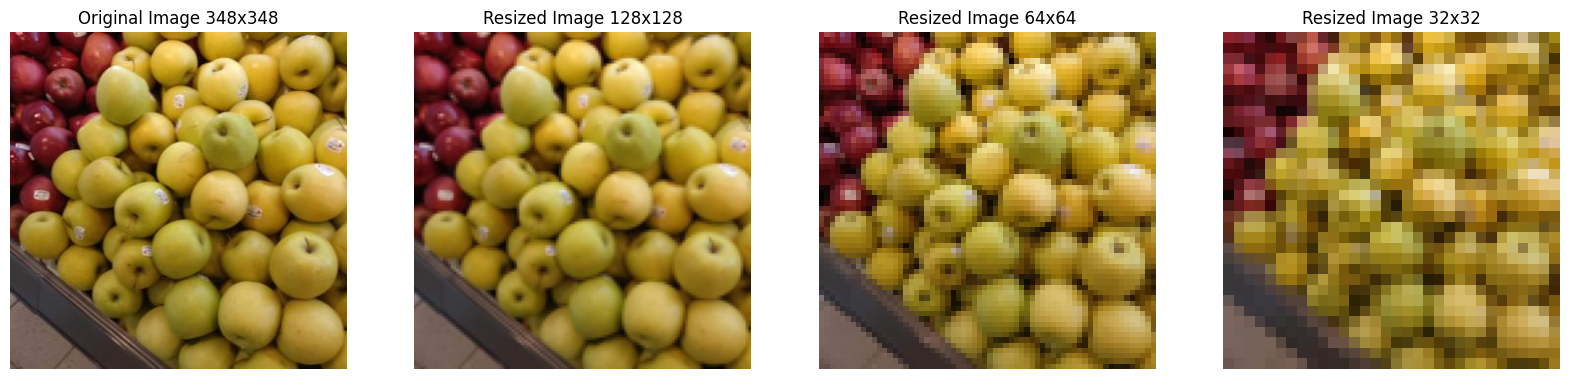

In [28]:
# preview the images in 4 different resolutions, original, 128x128, 64x64 and 32x32 in a nice grid

# Function to resize the image
def resize_image(image_path, size):
    with Image.open(image_path) as img:
        img_resized = img.resize(size)
        return img_resized
    
# Resize the image to 128x128
image_resized_128 = resize_image(image_path, (128, 128))

# Resize the image to 64x64
image_resized_64 = resize_image(image_path, (64, 64))

# Resize the image to 32x32
image_resized_32 = resize_image(image_path, (32, 32))

# Display the images
fig, ax = plt.subplots(1, 4, figsize=(20, 20))

# Original image
ax[0].imshow(image)
ax[0].set_title('Original Image 348x348')
ax[0].axis('off')

# Resized image 128x128
ax[1].imshow(image_resized_128)
ax[1].set_title('Resized Image 128x128')
ax[1].axis('off')

# Resized image 64x64
ax[2].imshow(image_resized_64)
ax[2].set_title('Resized Image 64x64')
ax[2].axis('off')

# Resized image 32x32
ax[3].imshow(image_resized_32)
ax[3].set_title('Resized Image 32x32')
ax[3].axis('off')

plt.show()


Usaremos una resolución de 128x128 pixeles para las imagenes, ya que es un tamaño adecuado para trabajar con las imagenes y no pierde un nivel de detalle significativo.

In [29]:
# Check if the directory already exists
if os.path.exists('GroceryStoreDataset/dataset/train_128x128'):
    print("Directory already exists. Skipping the process.")
else:
    # Create the directory
    os.makedirs('GroceryStoreDataset/dataset/train_128x128', exist_ok=True)

    # Function to resize and save the image
    def resize_and_save(image_path, size, save_path):
        with Image.open(image_path) as img:
            img_resized = img.resize(size)
            img_resized.save(save_path)

    # Create a dictionary to map class_id and coarse_class_id to their names
    class_id_to_name = df.set_index('Class ID (int)')['Class Name (str)'].to_dict()
    coarse_class_id_to_name = df.set_index('Coarse Class ID (int)')['Coarse Class Name (str)'].to_dict()

    # Resize and save all images in the train dataset
    for index, row in df_train.iterrows():
        image_path = row['Image Path']
        class_id = row['Class ID']
        coarse_class_id = row['Coarse Class ID']
        class_name = class_id_to_name[class_id]
        coarse_class_name = coarse_class_id_to_name[coarse_class_id]
        image_name = image_path.split('/')[-1]
        save_path = f'GroceryStoreDataset/dataset/train_128x128/{coarse_class_name}/{class_name}/{image_name}'
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        resize_and_save(image_path, (128, 128), save_path)

    # Check the number of images in the resized directory, it should be the same as the original directory

    # Count the number of images in the original directory
    original_image_count = sum([len(files) for r, d, files in os.walk('GroceryStoreDataset/dataset/train')])
    print(f"Number of images in the original directory: {original_image_count}")

    # Count the number of images in the resized directory
    resized_image_count = sum([len(files) for r, d, files in os.walk('GroceryStoreDataset/dataset/train_128x128')])
    print(f"Number of images in the resized directory: {resized_image_count}")

    # Check if the number of images in the original and resized directories are the same
    if original_image_count == resized_image_count:
        print("Number of images in the original and resized directories match.")
    else:
        print("Number of images in the original and resized directories do not match.")

Directory already exists. Skipping the process.


In [30]:
# add the column 'Image Path 128x128' to the df_train

# Add the 'Image Path 128x128' column to df_train with the path to the resized images
df_train['Image Path 128x128'] = df_train['Image Path'].apply(lambda x: x.replace('GroceryStoreDataset/dataset', 'GroceryStoreDataset/dataset/train_128x128'))

# Display the first few rows of df_train to verify
print(df_train.head())

                                                                                Image Path  Class ID  Coarse Class ID                                                                                     Image Path 128x128
0  GroceryStoreDataset/dataset/train/Fruit/Apple/Golden-Delicious/Golden-Delicious_001.jpg         0                0  GroceryStoreDataset/dataset/train_128x128/train/Fruit/Apple/Golden-Delicious/Golden-Delicious_001.jpg
1  GroceryStoreDataset/dataset/train/Fruit/Apple/Golden-Delicious/Golden-Delicious_002.jpg         0                0  GroceryStoreDataset/dataset/train_128x128/train/Fruit/Apple/Golden-Delicious/Golden-Delicious_002.jpg
2  GroceryStoreDataset/dataset/train/Fruit/Apple/Golden-Delicious/Golden-Delicious_003.jpg         0                0  GroceryStoreDataset/dataset/train_128x128/train/Fruit/Apple/Golden-Delicious/Golden-Delicious_003.jpg
3  GroceryStoreDataset/dataset/train/Fruit/Apple/Golden-Delicious/Golden-Delicious_004.jpg         0                

In [31]:
# remove 'train/' from the 'Image Path 128x128' column in df_train in all rows

# Remove 'train/' from the 'Image Path 128x128' column in df_train
df_train['Image Path 128x128'] = df_train['Image Path 128x128'].apply(lambda x: x.replace('train/', ''))

# remove 'Fruit', 'Packages' and 'Vegeragles' as we're no longer grouping by type of product
df_train['Image Path 128x128'] = df_train['Image Path 128x128'].apply(lambda x: x.replace('Fruit/', ''))
df_train['Image Path 128x128'] = df_train['Image Path 128x128'].apply(lambda x: x.replace('Packages/', ''))
df_train['Image Path 128x128'] = df_train['Image Path 128x128'].apply(lambda x: x.replace('Vegetables/', ''))
print(df_train.head())


                                                                                Image Path  Class ID  Coarse Class ID                                                                         Image Path 128x128
0  GroceryStoreDataset/dataset/train/Fruit/Apple/Golden-Delicious/Golden-Delicious_001.jpg         0                0  GroceryStoreDataset/dataset/train_128x128/Apple/Golden-Delicious/Golden-Delicious_001.jpg
1  GroceryStoreDataset/dataset/train/Fruit/Apple/Golden-Delicious/Golden-Delicious_002.jpg         0                0  GroceryStoreDataset/dataset/train_128x128/Apple/Golden-Delicious/Golden-Delicious_002.jpg
2  GroceryStoreDataset/dataset/train/Fruit/Apple/Golden-Delicious/Golden-Delicious_003.jpg         0                0  GroceryStoreDataset/dataset/train_128x128/Apple/Golden-Delicious/Golden-Delicious_003.jpg
3  GroceryStoreDataset/dataset/train/Fruit/Apple/Golden-Delicious/Golden-Delicious_004.jpg         0                0  GroceryStoreDataset/dataset/train_128x128/App

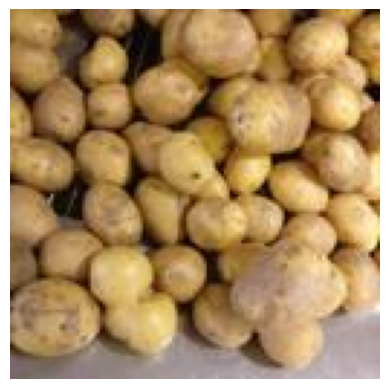

Resolución de la imagen: (128, 128)


In [32]:
# get an image of a different class to show the resolution and the image

# Load the image
image_path = df_train[df_train['Class ID'] == 74]['Image Path 128x128'].values[0]
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

# print the resolution of the image
print('Resolución de la imagen:', image.size)


#### **2.1.1. Aumento de datos**

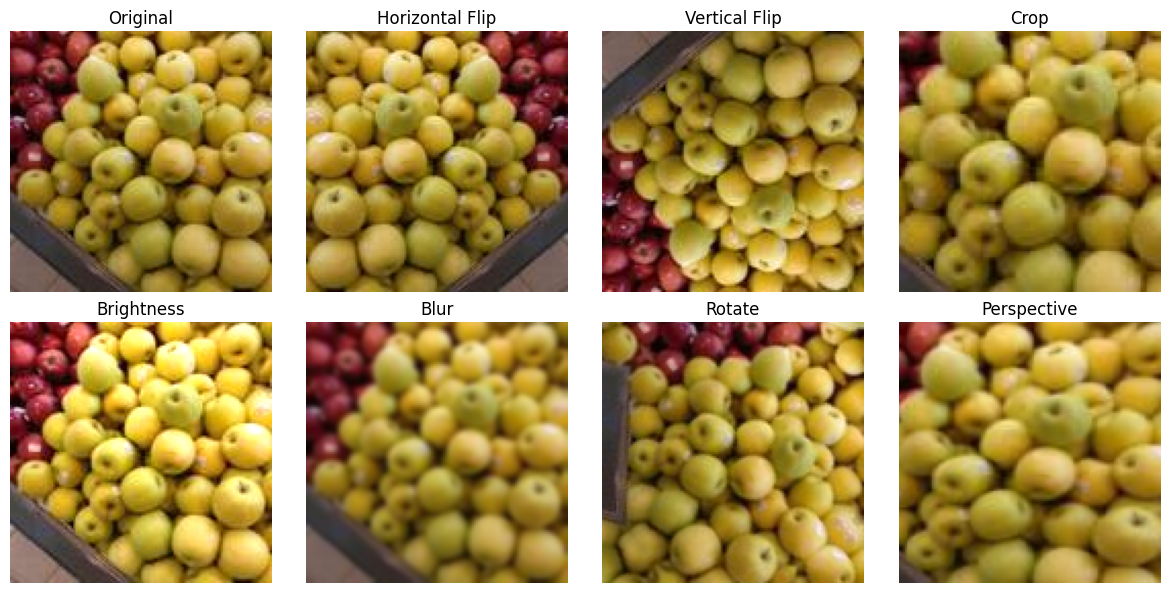

In [122]:
# Load a sample image
image = imageio.imread(df_train[df_train['Class ID'] == 0]['Image Path 128x128'].values[1])

# Define the augmentation techniques
augmenters = [
    iaa.Fliplr(),  # Horizontal flip
    iaa.Flipud(),  # Vertical flip
    iaa.Crop(percent=(0.15)),  # Crop
    iaa.Multiply((1.3)),  # Brightness
    iaa.GaussianBlur(sigma=(1.2)),  # Blur
    iaa.Affine(rotate=(53), mode='reflect'),
    iaa.PerspectiveTransform(scale=(0.13))
    
]

# Apply augmentations and store results
augmented_images = [aug(image=image) for aug in augmenters]

# Plot the original and augmented images in a grid
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

# Show the original image
axes[0].imshow(image)
axes[0].set_title('Original')
axes[0].axis('off')

# Show the augmented images
titles = ['Horizontal Flip', 'Vertical Flip', 'Crop', 'Brightness', 'Blur', 'Rotate', 'Perspective']
for i, (aug_img, title) in enumerate(zip(augmented_images, titles), 1):
    axes[i].imshow(aug_img)
    axes[i].set_title(title)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
from PIL import Image
import numpy as np
import imgaug.augmenters as iaa
import pandas as pd


# Check if the directory already exists
if os.path.exists('GroceryStoreDataset/dataset/train_augmented'):
    print("Directory already exists. Skipping the process.")
else:
    # Create the directory
    os.makedirs('GroceryStoreDataset/dataset/train_augmented', exist_ok=True)

    # Function to apply augmentations and save the image
    def augment_and_save(image_path, augmenters, save_dir, image_name):
        with Image.open(image_path) as img:
            img_np = np.array(img)
            # Save the original image
            original_save_path = os.path.join(save_dir, f'original_{image_name}')
            img.save(original_save_path)
            # Apply augmentations and save the augmented images
            for i, augmenter in enumerate(augmenters):
                augmented_img_np = augmenter(image=img_np)
                augmented_img = Image.fromarray(augmented_img_np)
                augmented_save_path = os.path.join(save_dir, f'augmented_{i}_{image_name}')
                augmented_img.save(augmented_save_path)

    # Create a dictionary to map class_id and coarse_class_id to their names
    class_id_to_name = df.set_index('Class ID (int)')['Class Name (str)'].to_dict()
    coarse_class_id_to_name = df.set_index('Coarse Class ID (int)')['Coarse Class Name (str)'].to_dict()

    # Apply augmentations and save all images in the train dataset
    for index, row in df_train.iterrows():
        image_path = row['Image Path']
        class_id = row['Class ID']
        coarse_class_id = row['Coarse Class ID']
        class_name = class_id_to_name[class_id]
        coarse_class_name = coarse_class_id_to_name[coarse_class_id]
        image_name = image_path.split('/')[-1]
        save_dir = f'GroceryStoreDataset/dataset/train_augmented/{coarse_class_name}/{class_name}'
        os.makedirs(save_dir, exist_ok=True)
        augment_and_save(image_path, augmenters, save_dir, image_name)

    # Check the number of images in the augmented directory, it should be the same as the original directory

    # Count the number of images in the original directory
    original_image_count = sum([len(files) for r, d, files in os.walk('GroceryStoreDataset/dataset/train')])
    print(f"Number of images in the original directory: {original_image_count}")

    # Count the number of images in the augmented directory
    augmented_image_count = sum([len(files) for r, d, files in os.walk('GroceryStoreDataset/dataset/train_augmented')])
    print(f"Number of images in the augmented directory: {augmented_image_count}")

    # Check if the number of images in the original and augmented directories are the same by a factor of 8
    if original_image_count * 8 == augmented_image_count:
        print("Number of images in the original and augmented directories match by a factor of 8.")
    else:
        print("Number of images in the original and augmented directories do not match.")

Number of images in the original directory: 2640
Number of images in the augmented directory: 21120
Number of images in the original and augmented directories match.
